In [1]:
%load_ext autoreload
%autoreload 2
import logging
import pandas as pd
import numpy as np
from hopfield import Hopfield
from hopfield_helper import *
import tensorflow as tf
from topicpy import gtex
import multiprocessing as mp
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

Creating directory /home/jovyan/.config/bioservices 


In [2]:
directory = "../cancers/breast/"

In [3]:
df = pd.read_csv(f'{directory}/topsbm/topsbm_level_0_topic-dist.csv', index_col=1).drop("i_doc", axis=1)
df=df.transpose().reset_index()
df.rename({"index":"id"}, axis=1, inplace=True)
#df.set_index("id", inplace=True)
df = df.set_index("id").transpose()
df = df.subtract(df.mean(axis=0),1).abs().divide(df.std(axis=0),1) ## DNW
#df = df.subtract(df.min(axis=0),1).abs().divide(df.max(axis=0)-df.min(axis=0),1) ## threshold should be 0.005
df.head(2)

id,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,...,Topic 390,Topic 391,Topic 392,Topic 393,Topic 394,Topic 395,Topic 396,Topic 397,Topic 398,Topic 399
doc,,,,,,,,,,,,,,,,,,,,,
87fcecde-b317-4518-bea1-cc8d14a18107.FPKM.txt.gz,0.161589,1.211077,1.383581,1.235106,0.448680,1.017490,1.356021,1.315820,0.812672,0.542880,...,0.814534,0.821082,1.313098,1.415218,1.415218,1.318374,1.415218,0.836411,1.262714,1.415218
bbf9a30d-3067-491b-9aea-0cb9bed91969.FPKM.txt.gz,1.192468,1.941760,0.863214,1.314526,1.129337,0.379144,1.056037,0.405201,0.479141,0.370233,...,0.475281,0.417633,0.403822,0.416223,0.416223,0.406419,0.416223,0.533580,0.514209,0.416223


In [4]:
df_files = pd.read_csv(f'{directory}/files.dat', index_col=0).reindex(index=df.index)
df["tissue"] = df_files["Subtype_Selected"]

In [64]:
threshold_f = lambda p: p>0.8
data_df=df.groupby("tissue").mean().applymap(threshold_f).astype(int)
df_threshold = df.transpose().drop("tissue", axis=0).applymap(threshold_f).astype(int)
data_tensor = tf.convert_to_tensor(data_df.values*2-1, dtype=tf.int8)
df_threshold_tensor = tf.convert_to_tensor(df_threshold.values.T, dtype=tf.int8)

In [65]:
model = Hopfield(data_tensor.shape[1])
model.load(data_tensor)
print(model)
model.train()

[2021-02-02 16:33:14,346] Creating model..
[2021-02-02 16:33:14,786] Loading data...


Hopfield model with 399 neurons and 6 memories loaded (max. 55) 


In [66]:
logging.getLogger("hopfield").setLevel("INFO")

In [67]:
reals = list(map(lambda sample: get_real_label(df, sample), df.index))
preds = get_predicted_labels(data_df.index, df_threshold_tensor, data_tensor, model)

In [68]:
print("Acc ",accuracy_score(reals, preds))
try:
    print("AUC ",roc_auc_score(tf.one_hot(tf.unique(preds)[1],3),tf.one_hot(tf.unique(reals)[1],3), multi_class="ovr"))
except:
    pass

Acc  0.4607201309328969
AUC  0.4386671855048058


In [69]:
model.reconstruct(data_tensor[0])[:10],data_tensor[0][:10]

(<tf.Tensor: shape=(10,), dtype=int64, numpy=array([-1, -1, -1, -1, -1,  1, -1,  1, -1, -1])>,
 <tf.Tensor: shape=(10,), dtype=int8, numpy=array([ 1,  1,  1,  1,  1, -1,  1, -1,  1,  1], dtype=int8)>)

In [70]:
@tf.function
def get_distance_matrix(data_tensor, model):
    return tf.map_fn(lambda A: tf.map_fn(lambda B: tf.reduce_min([tf.cast(hamming(model.reconstruct(A),B),tf.float64)]), tf.cast(data_tensor,tf.float64), parallel_iterations=6), tf.cast(data_tensor,tf.float64), parallel_iterations=6)

dist_matrix = get_distance_matrix(data_tensor, model)

<AxesSubplot:>

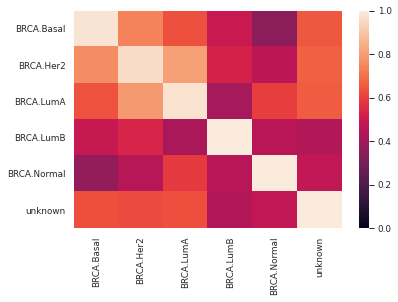

In [71]:
sns.heatmap(dist_matrix, vmin=0, vmax=1, xticklabels=data_df.index, yticklabels=data_df.index)

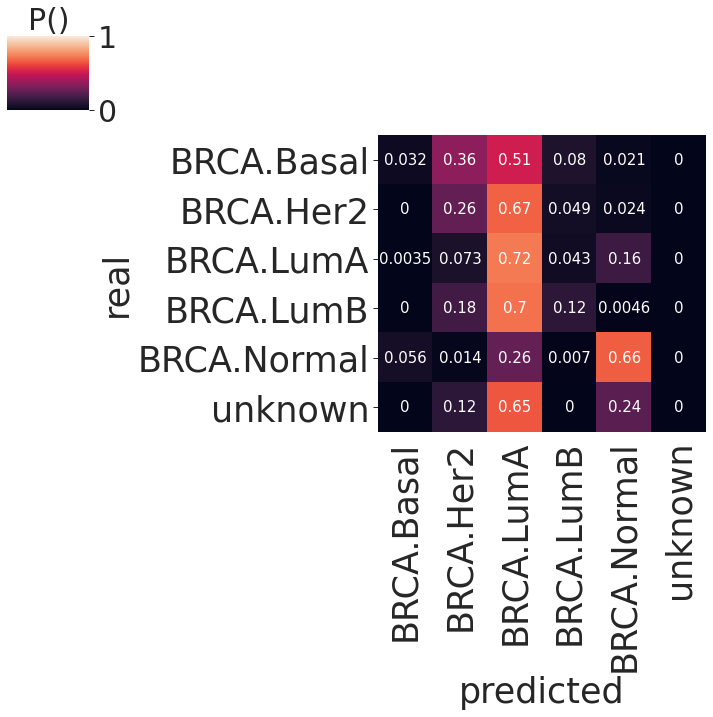

In [72]:
cm = sns.clustermap(confusion_matrix(reals, preds, normalize="true"),
                    vmin = 0,
                    vmax=1,  
                    row_cluster=False, 
                    col_cluster=False, 
                    xticklabels=data_df.index, 
                     yticklabels=data_df.index,
                    annot=True,
                    annot_kws={"fontsize":15})
ax = cm.ax_heatmap
fig = ax.get_figure()
ax.set_ylabel("real", fontsize=35, rotation=90)
ax.set_yticklabels(labels=data_df.index, rotation=0)
ax.yaxis.tick_left()
ax.yaxis.set_label_position("left")

ax.set_xticklabels(labels=data_df.index, rotation=90)
ax.set_xlabel("predicted",fontsize=35)
ax.tick_params(labelsize=35)

cax = cm.ax_cbar
cax.tick_params(labelsize=30)
cax.set_title("P()", fontsize=30)
plt.tight_layout()
#cm.savefig(f"predict_{label}.pdf")

plt.show()

In [73]:
for i,data in enumerate(data_tensor):
    print(data_df.index[i], data_df.index[predict(data, data_tensor, model).numpy()])

BRCA.Basal BRCA.Basal
BRCA.Her2 BRCA.Her2
BRCA.LumA BRCA.LumA
BRCA.LumB BRCA.LumB
BRCA.Normal BRCA.Normal
unknown unknown
